# Top tagging model with ResNet-50 

This is a training script about using top tagging data to train a ResNet-50 Neuron Network. <br>
The training is base on Keras and using tensorflow backend to run.

## Import necessary package and do gpu test.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 

import h5py 
import os
from keras.utils import np_utils
import tensorflow as tf
from tqdm import tqdm


Using TensorFlow backend.


## Input data with H5py package
Input data size: 1 channel image with shape 224x224. <br>
Input label size: 1 or 0 with onehot encoding. <br>
\# of input data(train(with val), test): 30000,6000

In [2]:
f = h5py.File('data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z', 'r')
treeArray = f['t_allpar_new'][()]
features = ['j1_etarot', 'j1_phirot','j_index']
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']


In [3]:
#features_df = pd.DataFrame(treeArray,columns=list(set(features)))
#labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))

features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_labels_df = features_labels_df.head(n = 1500000)
features_df = features_labels_df[features]
labels_df = features_labels_df[labels]

In [4]:
#features_labels_df = features_labels_df.head(n = 300000)
#features_df = features_labels_df[features].head(n = 300000)
#labels_df = features_labels_df[labels].head(n = 300000)

In [5]:
MaxParticles = 40
BinsX = 112
MinX = -0.8
MaxX =  0.8
BinsY = 112
MinY = -1.0
MaxY = 1.0

# Convert to nparray
labels_df = labels_df.drop_duplicates()
features_val = features_df.drop(['j_index'],axis=1).values
labels_val = labels_df.drop(['j_index'],axis=1).values

# get features
features_2dval = np.zeros((len(labels_df), BinsX, BinsY))
for i in tqdm(range(0, len(labels_df))):
    features_df_i = features_df[features_df['j_index'] == labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    xbins = np.linspace(MinX, MaxX, BinsX + 1)
    ybins = np.linspace(MinY, MaxY, BinsY + 1)

    x = features_df_i[features[0]]
    y = features_df_i[features[1]]
    w = features_df_i[features[2]]

    hist, xedges, yedges = np.histogram2d(x, y, weights=w, bins=(xbins, ybins))

    for ix in range(0, BinsX):
        for iy in range(0, BinsY):
            features_2dval[i, ix, iy] = hist[ix, iy]
features_val = features_2dval

100%|███████████████████████████████████████████████████████████████████████████| 28784/28784 [03:53<00:00, 123.23it/s]


In [6]:
features_val.shape

(28784, 112, 112)

In [7]:

images = np.stack([features_val, features_val, features_val],axis= -1)
label = labels_val

In [8]:
images.shape

(28784, 112, 112, 3)

In [9]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(images, label, test_size=0.2,
                                                                random_state=42)

In [10]:
X_train_val.shape

(23027, 112, 112, 3)

In [11]:
X_test.shape

(5757, 112, 112, 3)

In [12]:
del features_val
del features_df
del labels_df
del images
del label

## Construsting a sequential 
Construst a model with Keras pre-configured ResNet-50 and one Dense layer with Softmax activation function. <br>
Using Earlystopping and custom callback function to prevent training from overfitting and collect ROC/AUC data point. 

In [25]:
model = tf.keras.models.Sequential([
tf.keras.applications.ResNet50(weights=None, pooling='max',classes=2048,input_shape=(112,112,3)),
tf.keras.layers.Dense(1024,activation='relu'),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(5, activation='softmax'),
])
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              27784064  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 29,887,365
Trainable params: 29,834,245
Non-trainable params: 53,120
_________________________________________________________________


In [26]:
from tensorflow.keras.optimizers import Adam
adam = Adam(lr = 0.0001)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC(num_thresholds=200, curve='ROC')])

In [27]:
history = model.fit(X_train_val, y_train_val, batch_size = 128, epochs = 50, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)


Train on 17270 samples, validate on 5757 samples
Epoch 1/50
17270/17270 [==============================] - 58s 3ms/sample - loss: 0.2991 - auc_1: 0.9111 - val_loss: 1.0032 - val_auc_1: 0.6396
Epoch 2/50
17270/17270 [==============================] - 50s 3ms/sample - loss: 0.1028 - auc_1: 0.9870 - val_loss: 1.5108 - val_auc_1: 0.5023
Epoch 3/50
17270/17270 [==============================] - 51s 3ms/sample - loss: 0.0589 - auc_1: 0.9943 - val_loss: 1.5929 - val_auc_1: 0.5023
Epoch 4/50
17270/17270 [==============================] - 51s 3ms/sample - loss: 0.1003 - auc_1: 0.9826 - val_loss: 1.6172 - val_auc_1: 0.4986
Epoch 5/50
17270/17270 [==============================] - 51s 3ms/sample - loss: 0.0420 - auc_1: 0.9968 - val_loss: 1.7133 - val_auc_1: 0.5030
Epoch 6/50
17270/17270 [==============================] - 50s 3ms/sample - loss: 0.0365 - auc_1: 0.9975 - val_loss: 0.6878 - val_auc_1: 0.7643
Epoch 7/50
17270/17270 [==============================] - 51s 3ms/sample - loss: 0.0300 - auc

## Define function to visualize learning curve and prediction. <br><br>

In [28]:
print(y_test.shape)
X_test.shape

(5757, 5)


(5757, 112, 112, 3)

In [29]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i-1]
        df[label + '_pred'] = labels_pred[:,i-1]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'ResNet ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

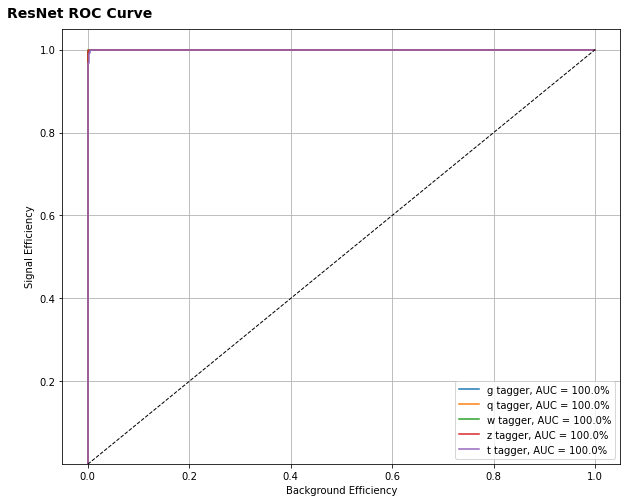

In [30]:
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t']
y_pred = makeRoc(X_test, y_test,labels, model, outputSuffix='ResNet')

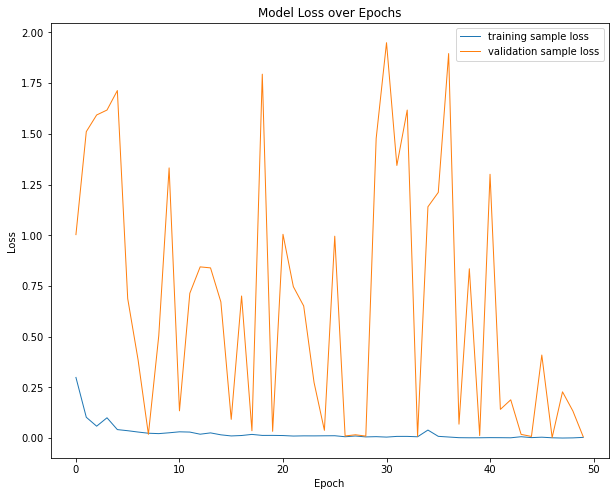

In [31]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

learningCurve(history)